In [ ]:
!pip install nltk
#!pip install pyspellchecker

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download(["punkt","wordnet"])
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from spellchecker import SpellChecker
from gensim import corpora


df= pd.read_csv("IMDB Dataset.csv") 
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [79]:
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

Hence, the sentiment is either postive or negative, we need to convert these values to binary values to feed it into our model

In [80]:
df["sentiment"]= pd.Series(np.where(df["sentiment"]=="positive",1,0))

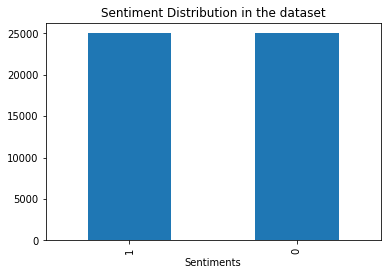

In [81]:
df["sentiment"].value_counts().plot.bar(title= "Sentiment Distribution in the dataset")
plt.xlabel("Sentiments")
plt.show()

In [82]:
def get_data(top_n = 5000):
    df_positive = df[df['sentiment'] == 1].head(top_n)
    df_negative = df[df['sentiment'] == 0].head(top_n)
    df_small = pd.concat([df_positive, df_negative])
    return df_small

df_small = get_data(top_n=5000)

df_small.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1


As we can see the dataset is quite balanced with almost equal number of data for both the target variables

## Text Preprocessing:-

1. Removing punctuations,symbols,html tags
2. lemmitisation, Spelling Correction
3. Tokenisation
##### left possibility- removing numbers

### Why do you need to preprocess this text?
Not all the information is useful in making predictions or doing classifications. Reducing the number of words will reduce the input dimension to your model. The way the language is written, it contains lot of information which is grammar specific. Thus when converting to numeric format, word specific characteristics like capitalisation, punctuations, suffixes/prefixes etc. are redundant. Cleaning the data in a way that similar words map to single word and removing the grammar relevant information from text can tremendously reduce the vocabulary. Which methods to apply and which ones to skip depends on the problem at hand.

In [83]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]+"

Lowercasing and removing all sorts of punctuations including html tags, urls

In [84]:
def clean_text(text):
  text = re.sub(TEXT_CLEANING_RE,' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    tokens.append(token)
  return " ".join(tokens)

df_small["review"]= df_small["review"].apply(lambda text: clean_text(text))

In [85]:
lemma= WordNetLemmatizer()
def lemmatize_text(text):
  return " ".join([lemma.lemmatize(word) for word in text.split()])

df_small["lemmatised_text"]= df_small["review"].apply(lambda text: lemmatize_text(str(text)))

In [86]:
df_small["tokenized_text"]=df_small["lemmatised_text"].apply(lambda text: word_tokenize(text))
df_small["tokenized_text"]

0        [one, of, the, other, reviewer, ha, mentioned,...
1        [a, wonderful, little, production, br, br, the...
2        [i, thought, this, wa, a, wonderful, way, to, ...
4        [petter, mattei, s, love, in, the, time, of, m...
5        [probably, my, all, time, favorite, movie, a, ...
                               ...                        
10038    [it, surprisingly, had, a, plot, i, ve, seen, ...
10039    [i, suppose, i, m, supposed, to, take, somethi...
10044    [this, is, strictly, for, pryor, fan, just, be...
10047    [the, only, saving, grace, of, this, movie, is...
10048    [this, may, contain, spoiler, br, br, where, t...
Name: tokenized_text, Length: 10000, dtype: object

In [87]:
#def stem(text):
  #ps=PorterStemmer()
  #return " ".join([ps.stem(word) for word in text.split()])

#df_small["review"]= df_small["review"].apply(lambda text: stem(text))

#spell= SpellChecker()
#def spellcheck(text):
  #misspelled_word= spell.unknown(text.split())
  #return " ".join([spell.correction(word) if word in misspelled_word else word for word in text.split()])

#df_small["review"]= df_small["review"].apply(lambda text: spellcheck(text))

Splitting into train and test set:-

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(df_small[['tokenized_text']], df_small['sentiment'],shuffle=True,test_size=0.2,random_state=10)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
Y_train = Y_train.to_frame()
Y_train = Y_train.reset_index()
Y_test = Y_test.to_frame()
Y_test = Y_test.reset_index()

In [89]:
if torch.cuda.is_available():
  device= torch.device("cuda")
else:
  device= torch.device("cpu")
print(device)

cpu


## Defining the Feed forward model.

I have taken  hidden layer with different neurons. And to start with have considered Relu activation function

In [90]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        
        # First Hidden Layer:-
        self.f1 = nn.Linear(input_dim, hidden_dim) 
        # Adding Non-linearity 
        self.relu1 = nn.ReLU()

        # Second Hidden Layer:-
        self.f2 = nn.Linear(hidden_dim, hidden_dim) 
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Third Hidden Layer:-
        self.f3 = nn.Linear(hidden_dim, hidden_dim) 
        # Non-linearity 3
        self.relu3 = nn.ReLU()

        # Output Layer
        self.f4 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
       
        # Linear function 1
        out = self.f1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.f2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 3
        out = self.f3(out)
        # Non-linearity 3
        out = self.relu3(out)

        #output
        out = self.f4(out)

        return F.softmax(out, dim=1)

In [91]:
# Function to return the dictionary
def make_dict(df_small):
  vocab_dict = corpora.Dictionary(df_small["tokenized_text"])
  return vocab_dict

# Make the dictionary:-
vocab_dict = make_dict(df_small)

In [92]:
Vocab_size = len(vocab_dict)
# Function to make bow vector to be used as input to network
def make_bow_vector(vocab_dict, sentence):
  vec = torch.zeros(Vocab_size, dtype=torch.float64, device=device)
  for word in sentence:
      vec[vocab_dict.token2id[word]] += 1
  return vec.view(1, -1).float()

In [93]:
def make_target(label):
    if label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([0], dtype=torch.long, device=device)

In [94]:
input_dim= Vocab_size
hidden_dim= 500
output_dim=2
num_epochs=10
learning_rate=0.1
# RUN TRAINING AND TEST

ff_nn_bow_model= FeedforwardNN(input_dim,hidden_dim,output_dim)
ff_nn_bow_model.to(device)

loss_function= nn.CrossEntropyLoss()
optimizer= optim.Adam(ff_nn_bow_model.parameters(), lr=learning_rate)

In [ ]:
#writing the loss value in a file
ffnn_loss_file_name = "ffnn_loss.csv"
f= open(ffnn_loss_file_name,"w")
f.write("iter.loss")
f.write("\n")
losses=[]
iter=0
batch_size=100
#starting training
for epoch in range(num_epochs):
  train_loss=0
  for index, row in X_train.iterrows():
    #Clearing the accumulated gradients
    # Zero out the gradients from the FFNN object. *THIS IS VERY IMPORTANT TO DO BEFORE CALLING BACKWARD()*
    optimizer.zero_grad()

    # Make the bag of words vector for stemmed tokens 
    bow_vec = make_bow_vector(vocab_dict, row["tokenized_text"])
      
    #Forward pass to get output
    probs = ff_nn_bow_model(bow_vec)

    #Getting the target label
    target = make_target(Y_train["sentiment"][index])

    #Calculate loss
    loss = loss_function(probs,target)
    
    #Accumulating the loss over time
    train_loss+=loss.item()
    
    #Getting gradients wrt paramters:-
    loss.backward()

    #Updating Paramters
    optimizer.step()

  f.write(str(epoch+1)+ "," + str(train_loss/len(X_train))  )
  f.write("\n")
  train_loss=0

f.close()

In [ ]:
bow_ff_nn_predictions = []
original_lables_ff_bow = []
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(vocab_dict, row)
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test["sentiment"][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))

In [ ]:
for epoch in range(0, num_epochs):
        ex_indices = [i for i in range(0, len(train_ys))]
        random.shuffle(ex_indices)
        total_loss = 0.0
        for idx in ex_indices:
            x = form_input(train_xs[idx])
            y = train_ys[idx]
            # Build one-hot representation of y
            y_onehot = torch.zeros(num_classes)
            y_onehot.scatter_(0, torch.from_numpy(np.asarray(y,dtype=np.long)), 1)
            # Zero out the gradients from the FFNN object. *THIS IS VERY IMPORTANT TO DO BEFORE CALLING BACKWARD()*
            ffnn.zero_grad()
            probs = ffnn.forward(x)
            # Can also use built-in NLLLoss as a shortcut here (takes log probabilities) but we're being explicit here
            loss = torch.neg(torch.log(probs)).dot(y_onehot)
            total_loss += loss
            loss.backward()
            optimizer.step()
        print("Loss on epoch %i: %f" % (epoch, total_loss))

   train_correct = 0
    for idx in range(0, len(train_xs)):
        # Note that we only feed in the x, not the y, since we're not training. We're also extracting different
        # quantities from the running of the computation graph, namely the probabilities, prediction, and z
        x = form_input(train_xs[idx])
        y = train_ys[idx]
        probs = ffnn.forward(x)
        prediction = torch.argmax(probs)
        if y == prediction:
            train_correct += 1
        print("Example " + repr(train_xs[idx]) + "; gold = " + repr(train_ys[idx]) + "; pred = " +\
              repr(prediction) + " with probs " + repr(probs))
    print(repr(train_correct) + "/" + repr(len(train_ys)) + " correct after training")